<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Sepehr Kazemi
### Student ID: 99106599

# Import necessary libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
from tqdm import tqdm
from scipy.stats import multivariate_normal

# Define the MNIST dataset and data loader

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Visualization

In [12]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

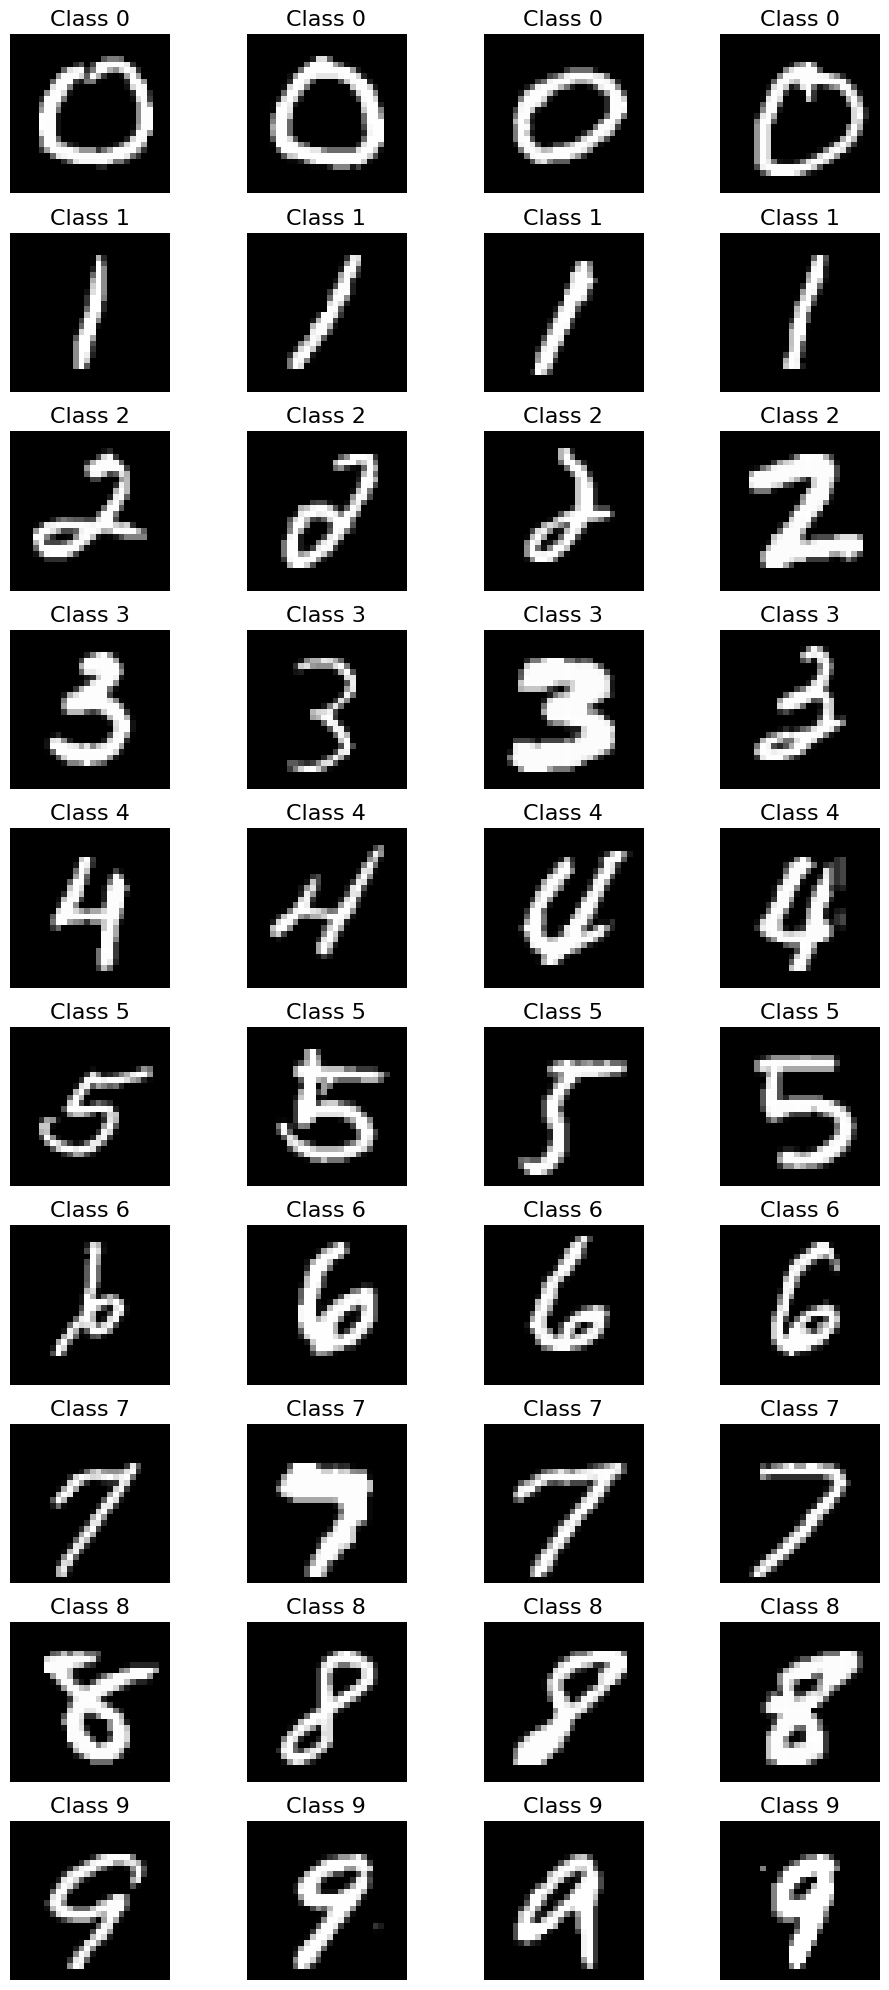

In [13]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [19]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim), nn.ReLU()
        )
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        x = x.reshape(x.size(0),-1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        y = y.reshape(x.size(0),28,28)
        return y, mu, logvar

In [20]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    criterion = nn.BCELoss(reduction='sum').to(device)
    reconstruction_loss = criterion(recon, data)
    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    loss = reconstruction_loss + kl_divergence
    return loss

In [22]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in tqdm(enumerate(train_loader),total=len(train_loader)):
            # TODO: Forward process
            data = data.to(device)
            recon, mu, logvar = model(data)
            # TODO: Flatten the data and recon tensors
            data = data.reshape(-1,784)
            recon = recon.reshape(-1,784)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model,'./best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:13<00:00, 70.09it/s]


VAE-MLP Epoch [1/10], Loss: 201.60708751627604
Sample Images:


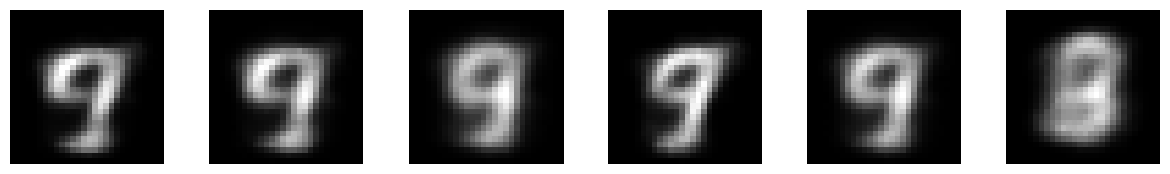


##################################################


100%|██████████| 938/938 [00:13<00:00, 70.41it/s]


VAE-MLP Epoch [2/10], Loss: 174.60512200520833
Sample Images:


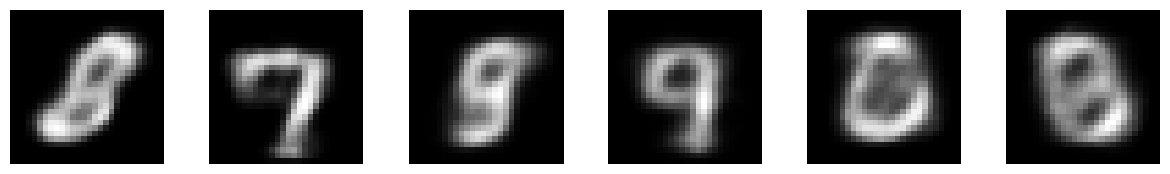


##################################################


100%|██████████| 938/938 [00:13<00:00, 70.57it/s]


VAE-MLP Epoch [3/10], Loss: 166.87542697753906
Sample Images:


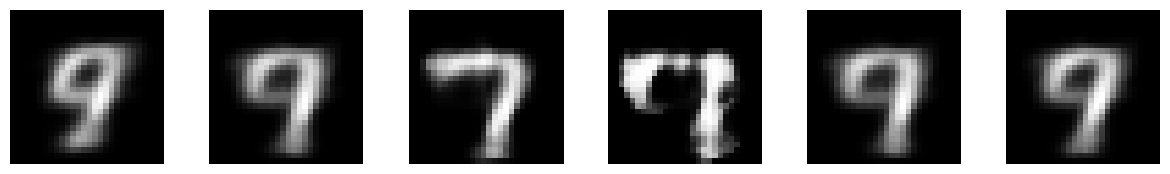


##################################################


100%|██████████| 938/938 [00:13<00:00, 70.53it/s]


VAE-MLP Epoch [4/10], Loss: 163.4200028483073
Sample Images:


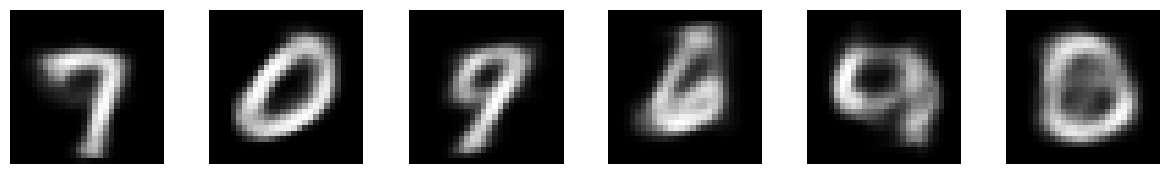


##################################################


100%|██████████| 938/938 [00:13<00:00, 70.79it/s]


VAE-MLP Epoch [5/10], Loss: 161.18937897135416
Sample Images:


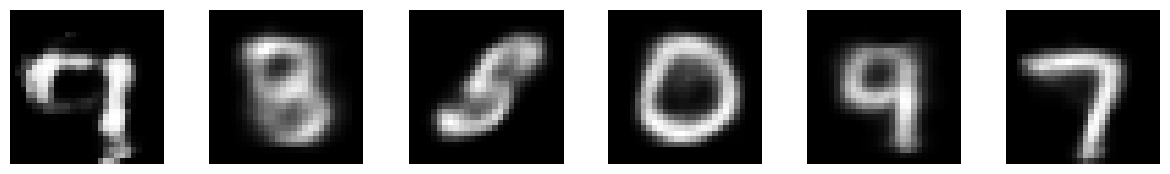


##################################################


100%|██████████| 938/938 [00:13<00:00, 68.44it/s]


VAE-MLP Epoch [6/10], Loss: 159.55956756998697
Sample Images:


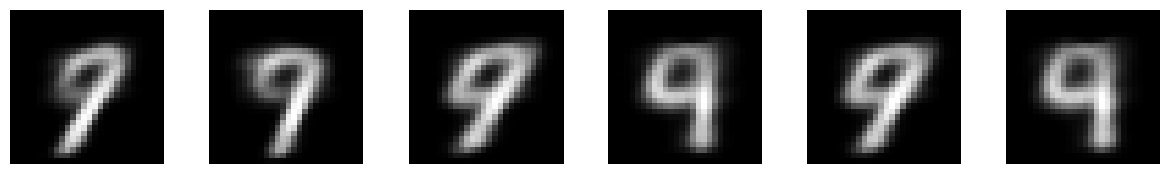


##################################################


100%|██████████| 938/938 [00:13<00:00, 71.40it/s]


VAE-MLP Epoch [7/10], Loss: 158.32000852864584
Sample Images:


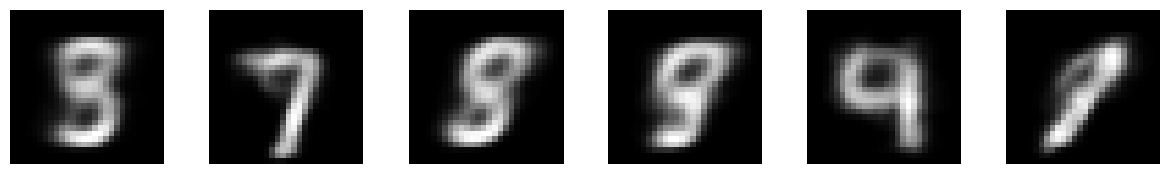


##################################################


100%|██████████| 938/938 [00:13<00:00, 70.62it/s]


VAE-MLP Epoch [8/10], Loss: 157.31833646647135
Sample Images:


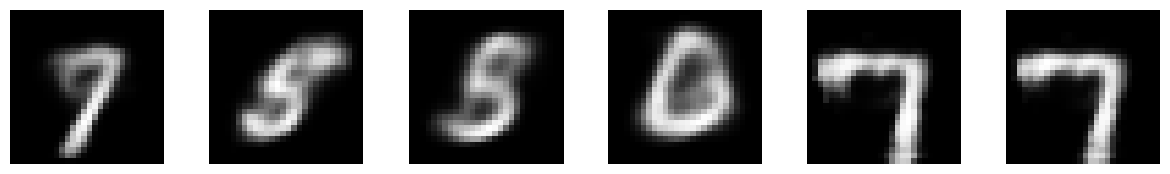


##################################################


100%|██████████| 938/938 [00:13<00:00, 71.42it/s]

VAE-MLP Epoch [9/10], Loss: 156.5103331217448
Sample Images:


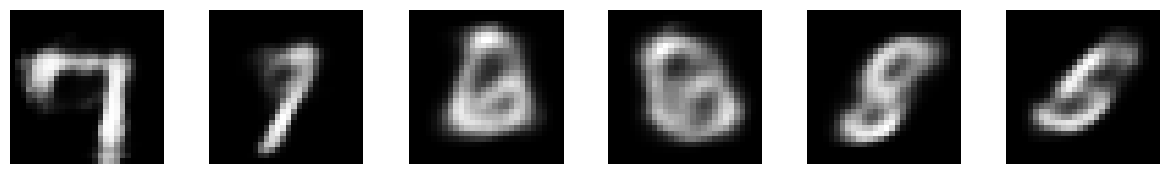


##################################################


100%|██████████| 938/938 [00:13<00:00, 71.22it/s]


VAE-MLP Epoch [10/10], Loss: 155.8875130452474
Sample Images:


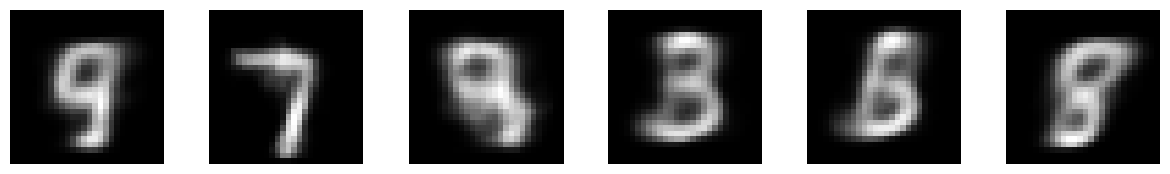

Best model saved as 'best_vae_mlp_model.pth'


In [23]:
# Train VAE-MLP
vae_mlp = VAE_MLP(784,256,2).to(device)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [5]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
    
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim), nn.ReLU()
        )
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.fc_class = nn.Linear(latent_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+num_classes, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y],dim=-1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_mu(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(z)

        reconstructed = self.decoder(torch.cat([z, y], dim=1))

        return reconstructed, mu, logvar, class_logits


In [6]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.reshape(data.size(0),-1)

    # TODO: Implement the reconstruction loss
    criterion_recons = nn.BCELoss(reduction='sum').to(device)
    reconstruction_loss = criterion_recons(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    criterion_class = nn.CrossEntropyLoss(reduction='sum').to(device)
    ce_loss = criterion_class(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [7]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
            optimizer.zero_grad()
            # One-hot encode the labels
            data = data.to(device)
            labels = labels.to(device)
            
            labels_one_hot = torch.zeros((labels.shape[0],10)).to(device)
            labels_one_hot[torch.arange(0,labels.shape[0],device=device)[:,None],labels[:,None]] = 1


            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon = None
            mu = None
            logvar = None
            class_logits = None
            loss = None

            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon,data,mu,logvar,class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model,'./best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################


100%|██████████| 938/938 [00:13<00:00, 68.27it/s]


CVAE-MLP Epoch [1/10], Loss: 184.97694290364583
Sample Images:


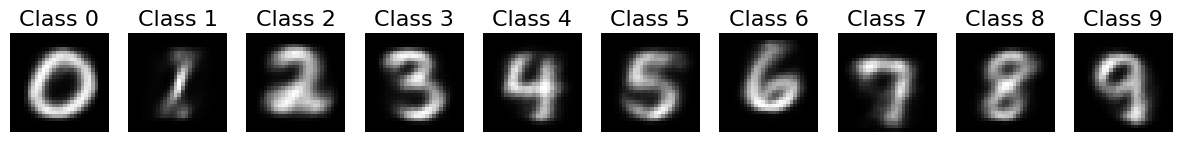


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.93it/s]


CVAE-MLP Epoch [2/10], Loss: 164.6041496500651
Sample Images:


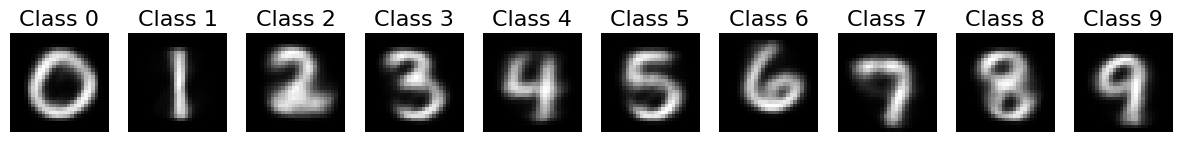


##################################################


100%|██████████| 938/938 [00:13<00:00, 68.01it/s]


CVAE-MLP Epoch [3/10], Loss: 160.42122674153646
Sample Images:


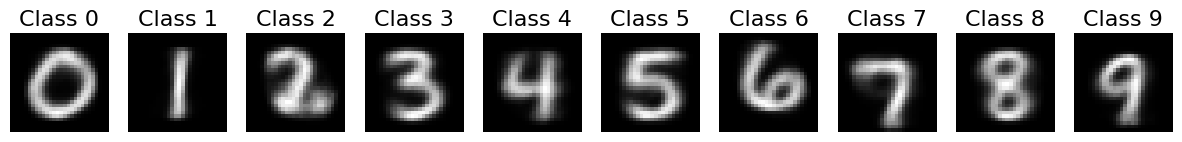


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.81it/s]


CVAE-MLP Epoch [4/10], Loss: 158.37813529459635
Sample Images:


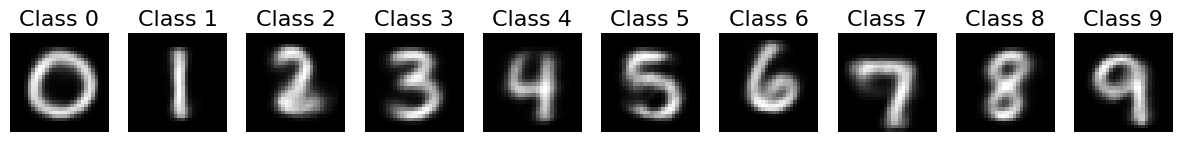


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.41it/s]


CVAE-MLP Epoch [5/10], Loss: 153.5302943766276
Sample Images:


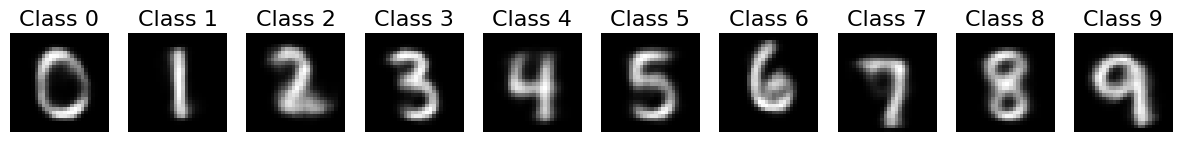


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.80it/s]


CVAE-MLP Epoch [6/10], Loss: 150.31193642578125
Sample Images:


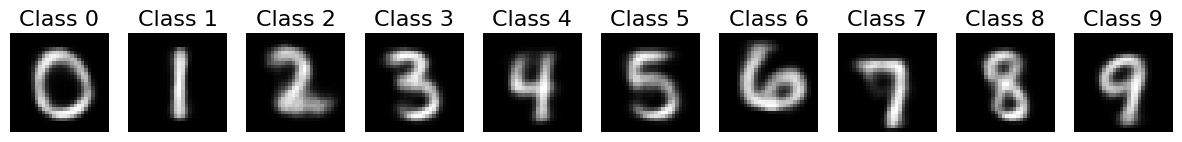


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.70it/s]


CVAE-MLP Epoch [7/10], Loss: 148.9919053873698
Sample Images:


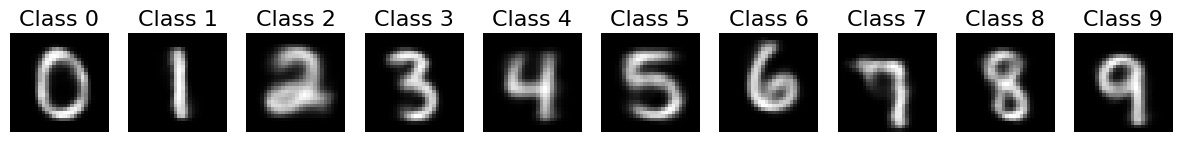


##################################################


100%|██████████| 938/938 [00:13<00:00, 68.10it/s]


CVAE-MLP Epoch [8/10], Loss: 148.2418773030599
Sample Images:


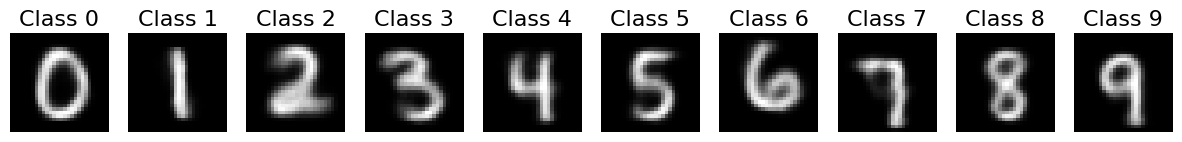


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.75it/s]


CVAE-MLP Epoch [9/10], Loss: 147.44817618815105
Sample Images:


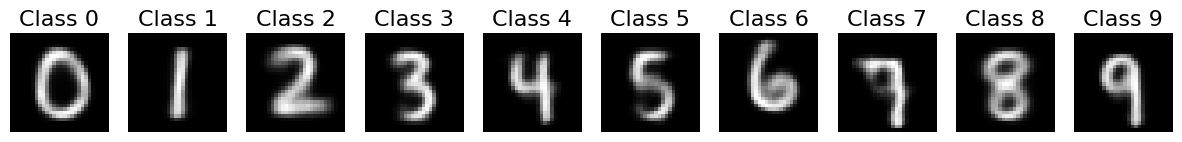


##################################################


100%|██████████| 938/938 [00:13<00:00, 67.90it/s]


CVAE-MLP Epoch [10/10], Loss: 147.00189762369791
Sample Images:


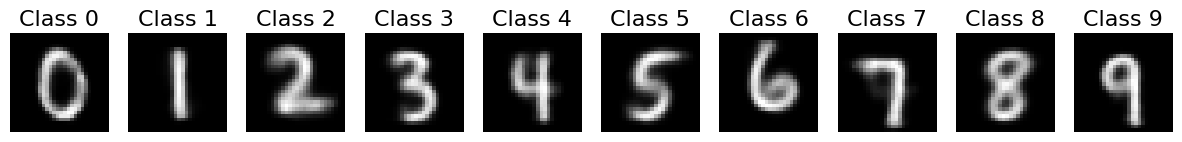

Best model saved as 'best_cvae_mlp_model.pth'


In [8]:
cvae_mlp = CVAE_MLP(784,256,2,10).to(device)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


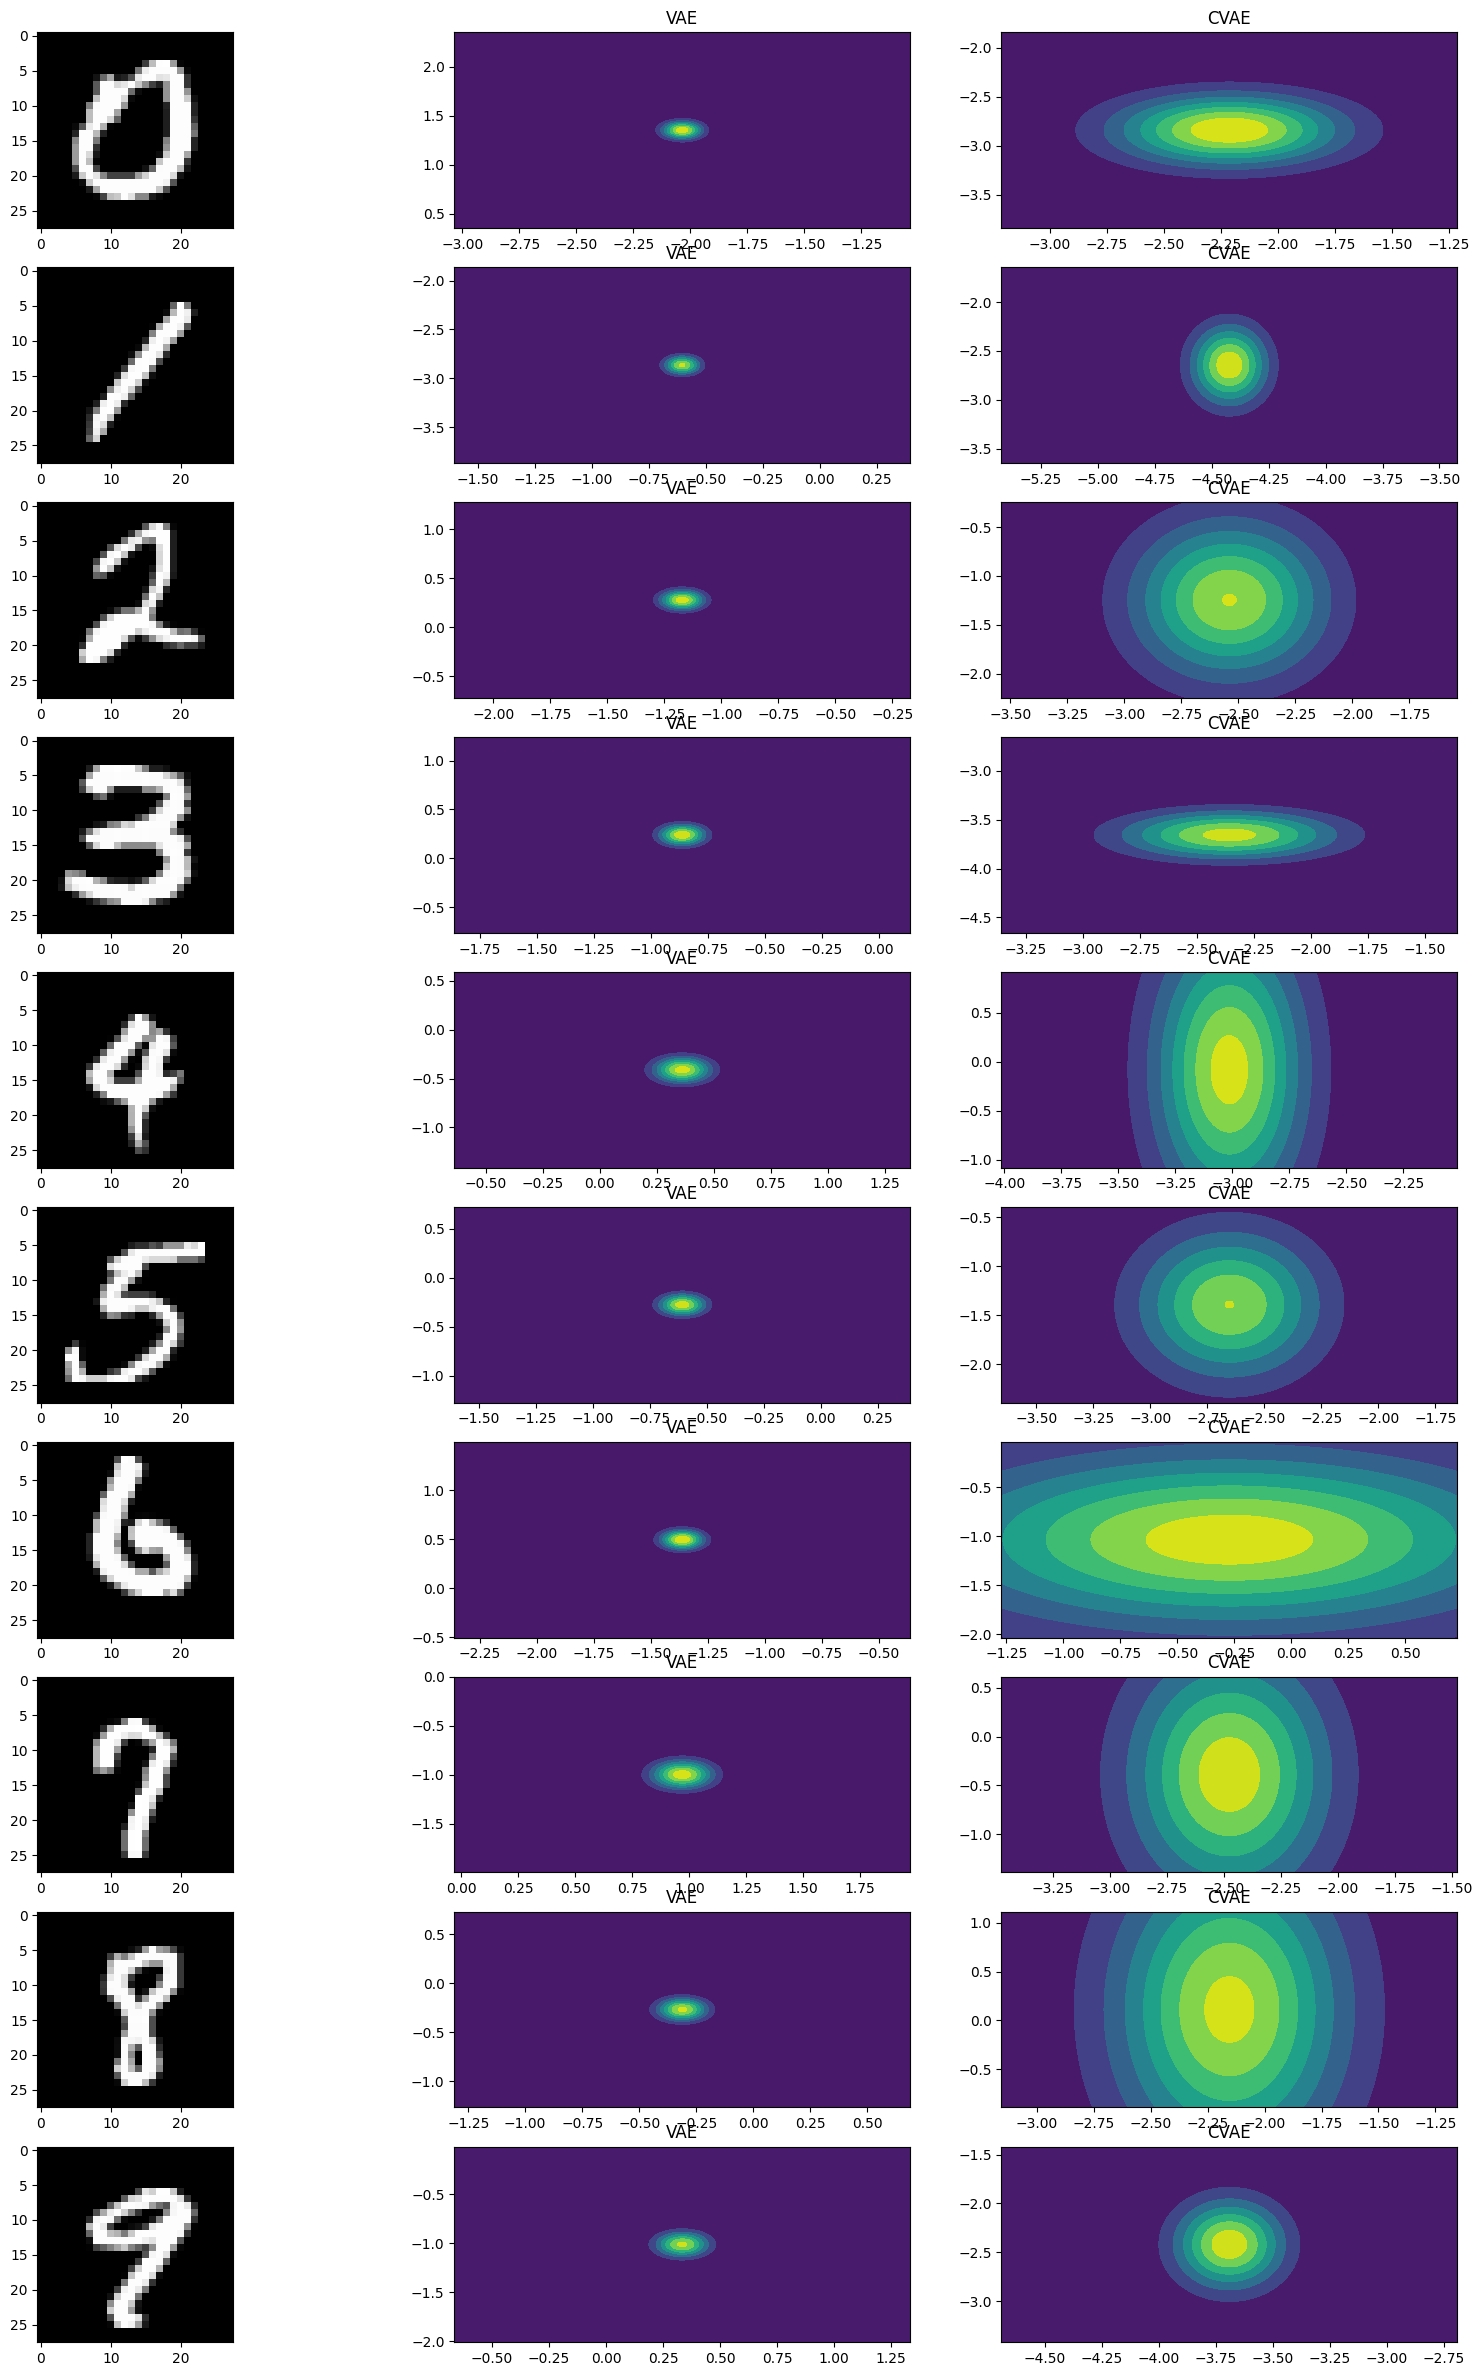

In [37]:
vae_mlp = VAE_MLP(784,256,2).to(device)
vae_mlp.load_state_dict(torch.load('./best_vae_mlp_model.pth'))
cvae_mlp = CVAE_MLP(784,256,2,10).to(device)
cvae_mlp.load_state_dict(torch.load('./best_cvae_mlp_model.pth'))

with torch.no_grad():
    vae_mlp.eval()
    cvae_mlp.eval()

    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels),3, figsize=(20, 30)) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(train_dataset.targets) if target == label]
        idx = random.sample(class_indices,1)
        image, target = train_dataset[idx[0]]
        image = image.to(device)
        image = image[None,:,:,:]
        one_hot = torch.zeros(1,1,10,device=device)
        one_hot[0,0,target] = 1

        axs[i, 0].imshow(image.cpu().squeeze(), cmap='gray')
        
        _, mu1, logvar1 = vae_mlp(image)
        _, mu2, logvar2, _  = cvae_mlp(image,one_hot)
        mu1 = mu1.cpu().squeeze()
        mu2 = mu2.cpu().squeeze()
        logvar1 = logvar1.cpu().squeeze()
        logvar2 = logvar2.cpu().squeeze()
        std1 = torch.exp(0.5*logvar1)
        std2 = torch.exp(0.5*logvar2)

        x1, y1 = np.meshgrid(np.linspace(mu1[0]-3*std1[0], mu1[0]+3*std1[0], 100), np.linspace(mu1[1]-3*std1[1], mu1[1]+3*std1[1], 100))
        x1, y1 = np.meshgrid(np.linspace(mu1[0]-1, mu1[0]+1, 100), np.linspace(mu1[1]-1, mu1[1]+1, 100))
        pos1 = np.dstack((x1, y1))
        gaussian1 = multivariate_normal(mu1, torch.diag(std1**2))
        pdf1 = gaussian1.pdf(pos1)
        
        axs[i,1].contourf(x1, y1, pdf1, cmap='viridis')
        axs[i,1].set_title('VAE')

        x2, y2 = np.meshgrid(np.linspace(mu2[0]-3*std2[0], mu2[0]+3*std2[0], 100), np.linspace(mu2[1]-3*std2[1], mu2[1]+3*std2[1], 100))
        x2, y2 = np.meshgrid(np.linspace(mu2[0]-1, mu2[0]+1, 100), np.linspace(mu2[1]-1, mu2[1]+1, 100))
        pos2 = np.dstack((x2, y2))
        gaussian2 = multivariate_normal(mu2, torch.diag(std2**2))
        pdf2 = gaussian2.pdf(pos2)
        
        axs[i,2].contourf(x2, y2, pdf2, cmap='viridis')
        axs[i,2].set_title('CVAE')

As we can See, the distribution of CVAE depends on some aditional information that we give, for example the image of 2 and 3 are somehow the same and in VAE the distribution is the same too(the mean and variance are approximatley the same). but in CVAE the have totaly different mu and sigma. in general the CVAE can encode more valuable information that may not infer thorigh image but AVE just infer information through image. also the CVA has larger variance due to the fact where an number can be written in various format due to handwrintg of the author. but AVE has small variance becasue it just consider the image not the fact that it is number 2 for example. but CVAE consider that it is number 2 chich can be written in various formats so it has lager variance and can better model the content of the image.